# Prophet: Forecasting Algorithms

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.exponential_smoothing.ets import ETSModel as ETS
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HW
from sktime.forecasting.fbprophet import Prophet
from prophet import Prophet as FBProphet
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, r2_score as R2

warnings.filterwarnings('ignore')
np.set_printoptions(precision=4, suppress=True)
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

## 1. ARIMA
[ARIMA] (AutoRegressive Integrated Moving Average) is an statistical model aiming to demonstrate the auto-correlations in time series data. The term *auto* means we are examining the relationship between our series with historical versions of itself (lagged series).

[ARIMA]: https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

### 1.1. ARIMA model

#### ARIMA functions
In a nutshell, ARIMA is a combination of 3 separated processes:

- Integration, $\text{I}(d)$. In this process, the model keeps differencing a time series until it's stationary. The parameter $d$ is the order of differencing and is determined using ADF test. The term *integration* shares the same meaning as summing, which implies the reverse of differencing.

- Auto-Regressive, $\text{AR}(p)$. In this process, we perform a linear regression model where input variables are lagged versions of our data. The parameter $p$ indicates the maximum lag degree and is determined using PACF of a stationary series: when a coefficient suddenly drops to 0, then the corresponding lag is a possible value for $p$. The $\text{AR}(p)$ function is:

$$\begin{aligned}
\hat{y}_t
&= c+\phi_1y_{t-1}+\phi_2y_{t-2}+\dots+\phi_py_{t-p} \\
&= c+(\phi_1B+\phi_2B^2+\dots+\phi_pB^p)y_t \\
\end{aligned}$$

- Moving Average model, $\text{MA}(q)$. It models our time series as a linear combination of past error (denoted $\epsilon$, where $\epsilon_{t-k}=y_{t-k}-\phi_1 y_{t-k-1}$). The parameter $q$ indicates the maximum lag degree and is determined using ACF chart of a stationary series, in a similar decision-making process as for $p$. The $\text{MA}(q)$ functions is:

$$\begin{aligned}
\hat{y}_t
&= c+\theta_1\epsilon_{t-1}+\theta_2\epsilon_{t-2}+\dots+\theta_q\epsilon_{t-q} \\
&= c+(\theta_1B+\theta_2B^2+\dots+\theta_qB^q)\epsilon_t \\
\end{aligned}$$

The entire model $\text{ARIMA}(p,d,q)$ is written as below:

$$(1-B)^d\hat{y}_t=c+(\phi_1B+\phi_2B^2+\dots+\phi_pB^p)(1-B)^dy_t+(\theta_1B+\theta_2B^2+\dots+\theta_qB^q)\epsilon_t$$

#### Procedure
- *Estimation*. ARIMA estimates its parameters $c,\phi_1,\phi_2,\dots,\phi_p,\theta_1,\theta_2,\dots,\theta_q$ either by minimizing sum of squared errors ([OLS]) or by maximizing likelihood ([MLE]). Both methods return the same result.

- *Point forecasting*. It's obvious, by looking at ARIMA function, that each observation at time $t$ is modeled using previous step $t-1,t-2,\dots$. This prediction is written $\hat{y}_{t|t-1}$. As we have known all values up to time $T$, the forecasting is done in a *recursive* behaviour: $\hat{y}_{T+1|T},\hat{y}_{T+2|T+1},\dots,\hat{y}_{T+H|T+H-1}$.

- *Prediction interval*. Being a regression model, ARIMA assumes that fitted residuals are normally distributed. Thus the confidence interval is given by $z_{\alpha/2}\sigma_H$ where $\alpha$ is significance level and $\sigma_H$ is the forecast standard deviation, it is proportional to the variance of residuals and $H$. But also note that when the above assumption is not hold, then prediction interval may be incorrect.

[OLS]: https://en.wikipedia.org/wiki/Ordinary_least_squares
[MLE]: https://en.wikipedia.org/wiki/Maximum_likelihood_estimation

#### Model selection
Model selection (also known as hyperparameters tuning) for ARIMA is the process of choosing appropriate values for $p$, $q$ and $d$. While the selection of $d$ is very straightforward, we would want to put more focus on tuning $p$ and $q$. As described earlier, viable values for $p$ and $q$ can be obtained by looking at PACF and ACF charts of the differenced series, respectively. However, this method usually returns a number of choices rather than guarantees a single optimal selection. Thus we treat it as a tool for limiting potential candidates, then perform greedy search. The objective of exhausted search in ARIMA is to minimize an *information criterion*, which has several options:
- [Akaike's Information Criterion], $\text{AIC} = -2 \log(L) + 2(p+q+k+1)$
- [Bayesian Information Criterion], $\text{BIC} = \text{AIC} + [\log(T)-2](p+q+k+1)$
- AICc, a corrected version of AIC for small data, in which time series is usually the case. When $n\rightarrow\infty$, AICc converges to AIC.

All the above information criteria are constructed of the *loss* part and the *regularization* part. The regularization part prevents the model from adding too many explanatory variables and makes sure the model has a good forecasting power. It is recommended to use AICc in real-world tasks.

[Akaike's Information Criterion]: https://en.wikipedia.org/wiki/Akaike_information_criterion
[Bayesian Information Criterion]: https://en.wikipedia.org/wiki/Bayesian_information_criterion

### 1.2. Extensions

#### SARIMA
SARIMA (Seasonal ARIMA) is an extended version of ARIMA so that it is capable of learning seasonal patterns. The new model is written as:

$$\text{ARIMA} (p,d,q) \times (P,D,Q)_m$$

where $m$ is sesonal period and $(P,Q,D)$ are seasonal hyperparameters. Since SARIMA is very complicated, writing the entire function down is not convenient; it's better going through each of its newly added components.
- $m$: the seasonal period. It is very easy to be pointed out after doing some analyses.
- $D$: the order of seasonal differencing. The process is to apply seasonal differencing first to *de-seasonality*, then apply non-seasonal differencing to *de-trend*, until our data is stationary. Basically, after performing both types of differencing, we end up working on the series $(1-B^m)^D(1-B)^dy_t$.
- $P$: the seasonal lag degree for auto-regressive model. For example, we are estimating monthly profit using profit of this month last year, this month 2 years ago,..., this month $P$ years ago. Viable values for $P$ are also determined using PACF, but this time we only look at seasonal lags.
- $Q$: the seasonal lag degree for moving average model. We can also select $Q$ by looking at seasonal lags in ACF.

#### SARIMAX
SARIMAX (SARIMA with eXogenous variables) adds other independent variables $\mathbf{x}_1,\mathbf{x}_2,\dots$ to the SARIMA function. This function, stand alone, is given by:

$$\hat{\mathbf{y}}=c+\beta_1\mathbf{x}_1+\beta_2\mathbf{x}_2+\dots$$

Exogenous variables should be predictable, for examples: holidays, so they can be used to forecast in the same time step. If we don't know their values in the future, we can only use them to study their effects on $\mathbf{y}$.

#### VAR
[VAR](https://en.wikipedia.org/wiki/Vector_autoregression) (Vector AutoRegression) is a generalization of the univariate autoregression model for forcasting a vector of time series. In this model, all variables are treated symmetrically - all of them are *endogenous*. The structure of VAR is each variable is a linear function of past lags of itself and past lags of the other variables, given in matrix notation as below:

$$\hat{\mathbf{y}}_{t}=
\mathbf{c}+
\boldsymbol{\phi}_1\circ\mathbf{y}_{t-1}+
\boldsymbol{\phi}_2\circ\mathbf{y}_{t-2}+
\cdots+
\boldsymbol{\phi}_p\circ\mathbf{y}_{t-p}+
\boldsymbol{\epsilon}_t
$$

where:
- $\mathbf{y}_t$ is a vector storing observations at time $t$ of all time series, $t=1,2\dots,T$
- $\mathbf{c}$ is the vector of intercepts
- $\boldsymbol{\phi}_1,\dots,\boldsymbol{\phi}_p$ are vectors of coefficients at each different lags
- $p$ is the maximum order of auto-regressive
- $\boldsymbol{\epsilon}_t$ is white noise

Before fit our data into VAR, all variables should be stationary. The model will then automatically select the most suitable value of $p$ be considering different criteria: $\text{AIC}$, $\text{FPE}$, $\text{SC}$ and $\text{HQIC}$.

### 1.3. Implementation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, suppress=True)
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, r2_score as R2

import warnings; warnings.filterwarnings('ignore')

#### SARIMAX implementation
We are going to implement SARIMAX's original form via class [`ARIMA`] or state space form via class [`SARIMAX`]. They both use the same hyperparameters; the earlier class is useful in extracting model components while the later supports forecasting better.
- `order`: the non-seasonal orders in the form of a tuple $(p,d,q)$, defaults to *(1, 0, 0)*. $d$ must be an integer, while $p$ and $q$ can be an integer (using all lagged series up to that value) or a list (using only specific lags).
- `seasonal_order`: the seasonal orders in the form of a tuple $(P,D,Q,m)$, defaults to *(0, 0, 0, 0)*. $D$ and $m$ must be an integer; $P$ and $Q$ can be either an integer or a list.

[`ARIMA`]: https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html
[`SARIMAX`]: https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [2]:
dfQty = pd.read_csv('../data/purchase_quantity.csv')
dfQty = dfQty.assign(date=dfQty.date.astype('datetime64'))
y = dfQty.set_index('date').quantity.asfreq('d')
y.head()

date
2019-01-11    189.82
2019-01-12    461.89
2019-01-13       NaN
2019-01-14       NaN
2019-01-15       NaN
Freq: D, Name: quantity, dtype: float64

In [3]:
model = SARIMAX(y, order=(2,1,3), seasonal_order=(2,1,2,7)).fit()

In [177]:
model.summary().tables[0]

Dep. Variable:,quantity,No. Observations:,696
Model:,"SARIMAX(2, 1, 3)x(2, 1, [1, 2], 7)",Log Likelihood,-1858.433
Date:,"Tue, 28 Jun 2022",AIC,3736.866
Time:,16:41:54,BIC,3782.204
Sample:,01-11-2019,HQIC,3754.406
,- 12-06-2020,,
Covariance Type:,opg,,


In [178]:
model.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.8515,1.040,0.818,0.413,-1.188,2.891
ar.L2,-0.4002,0.679,-0.589,0.556,-1.732,0.931
ma.L1,-1.2415,1.086,-1.143,0.253,-3.371,0.888
ma.L2,0.5936,1.124,0.528,0.597,-1.609,2.796
ma.L3,-0.3361,0.310,-1.083,0.279,-0.944,0.272
ar.S.L7,-0.6523,0.832,-0.784,0.433,-2.284,0.979
ar.S.L14,0.0629,0.319,0.198,0.843,-0.562,0.687
ma.S.L7,-0.3510,0.791,-0.444,0.657,-1.901,1.199
ma.S.L14,-0.5668,0.744,-0.762,0.446,-2.024,0.891
sigma2,2.556e+05,2.94e+04,8.699,0.000,1.98e+05,3.13e+05


:::{note}

Statsmodels distinguishes *forecast* (for future values) and *prediction* (for observed values). Thus, we will work on two separated methods.

:::

In [179]:
forecaster = model.get_forecast(steps=7)
forecaster.summary_frame(alpha=0.95)

quantity,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-12-07,709.980037,530.200523,676.732870,743.227203
2020-12-08,747.900832,626.328889,708.625765,787.175898
2020-12-09,945.555913,682.462069,902.760916,988.350910
2020-12-10,1010.003658,690.453033,966.707573,1053.299743
2020-12-11,962.607449,689.159342,919.392487,1005.822410
2020-12-12,1008.861260,686.040604,965.841864,1051.880656
2020-12-13,914.228175,678.455653,871.684408,956.771943


In [82]:
predictor = model.get_prediction()
predictor.summary_frame(alpha=0.95)

quantity,mean,mean_se,mean_ci_lower,mean_ci_upper
date,,,,
2019-01-11,0.000000,1633.762976,-102.448012,102.448012
2019-01-12,180.327594,1289.382228,99.474588,261.180599
2019-01-13,441.486381,1287.788377,360.733322,522.239441
2019-01-14,441.291429,1750.437348,331.527143,551.055715
2019-01-15,428.189605,2123.620260,295.024221,561.354989
...,...,...,...,...
2020-12-02,794.631547,535.515548,761.051093,828.212002
2020-12-03,1049.842517,534.571725,1016.321247,1083.363788
2020-12-04,1222.312068,527.366149,1189.242636,1255.381500


#### VAR implementation
Statsmodels implements VAR's statespace form via class [`VARMAX`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.varmax.VARMAX.html).

In [4]:
def Stationary_test(s):
    from statsmodels.tsa.stattools import adfuller
    stat, pval, _, _, crits, _ = adfuller(s, regression='nc')
    result = pval < 0.05
    
    conclusion = 'stationary' if result else 'non-stationary'
    sign = '<' if result else '>'
    
    mess = f'p-value={pval:6f} {sign} 0.05 | data is {conclusion}'
    print(mess)

In [5]:
dfCpi = pd.read_csv('../data/cpi.csv')
dfCpi = dfCpi.astype({'month': 'datetime64'})
dfCpi = dfCpi.set_index('month')
dfCpi.head()

,ex_rate,money_supply,inf
month,,,
2009-01-01,16954,1.582872e+06,15.536579
2009-02-01,16953,1.722413e+06,6.701754
2009-03-01,16991,1.830077e+06,2.417558
2009-04-01,17941,1.914078e+06,4.602838
2009-05-01,18544,1.964660e+06,9.696635


In [5]:
for i in dfCpi.columns:
    Stationary_test(dfCpi[i])

p-value=0.999465 > 0.05 | data is non-stationary
p-value=1.000000 > 0.05 | data is non-stationary
p-value=0.322387 > 0.05 | data is non-stationary


In [6]:
dfCpiDif = dfCpi.diff().dropna()
for i in dfCpiDif.columns:
    Stationary_test(dfCpiDif[i])

p-value=0.000000 < 0.05 | data is stationary
p-value=0.551794 > 0.05 | data is non-stationary
p-value=0.005036 < 0.05 | data is stationary


In [7]:
dfCpiDif = dfCpi.diff().diff().dropna()
for i in dfCpiDif.columns:
    Stationary_test(dfCpiDif[i])

p-value=0.000000 < 0.05 | data is stationary
p-value=0.000000 < 0.05 | data is stationary
p-value=0.000007 < 0.05 | data is stationary


In [8]:
model = VARMAX(dfCpiDif)
model = model.fit(maxlags=4, ic='aic', verbose=True)
model.summary()

Dep. Variable:,"['ex_rate', 'money_supply', 'inf']",No. Observations:,42
Model:,VAR(1),Log Likelihood,-950.816
,+ intercept,AIC,1937.633
Date:,"Thu, 14 Jul 2022",BIC,1968.911
Time:,13:53:39,HQIC,1949.097
Sample:,03-01-2009,,
,- 08-01-2012,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"1.41, 3.19, 0.00",Jarque-Bera (JB):,"91.82, 104.75, 1.20"
Prob(Q):,"0.23, 0.07, 0.95",Prob(JB):,"0.00, 0.00, 0.55"
Heteroskedasticity (H):,"0.02, 0.44, 0.14",Skew:,"1.27, 1.72, -0.09"


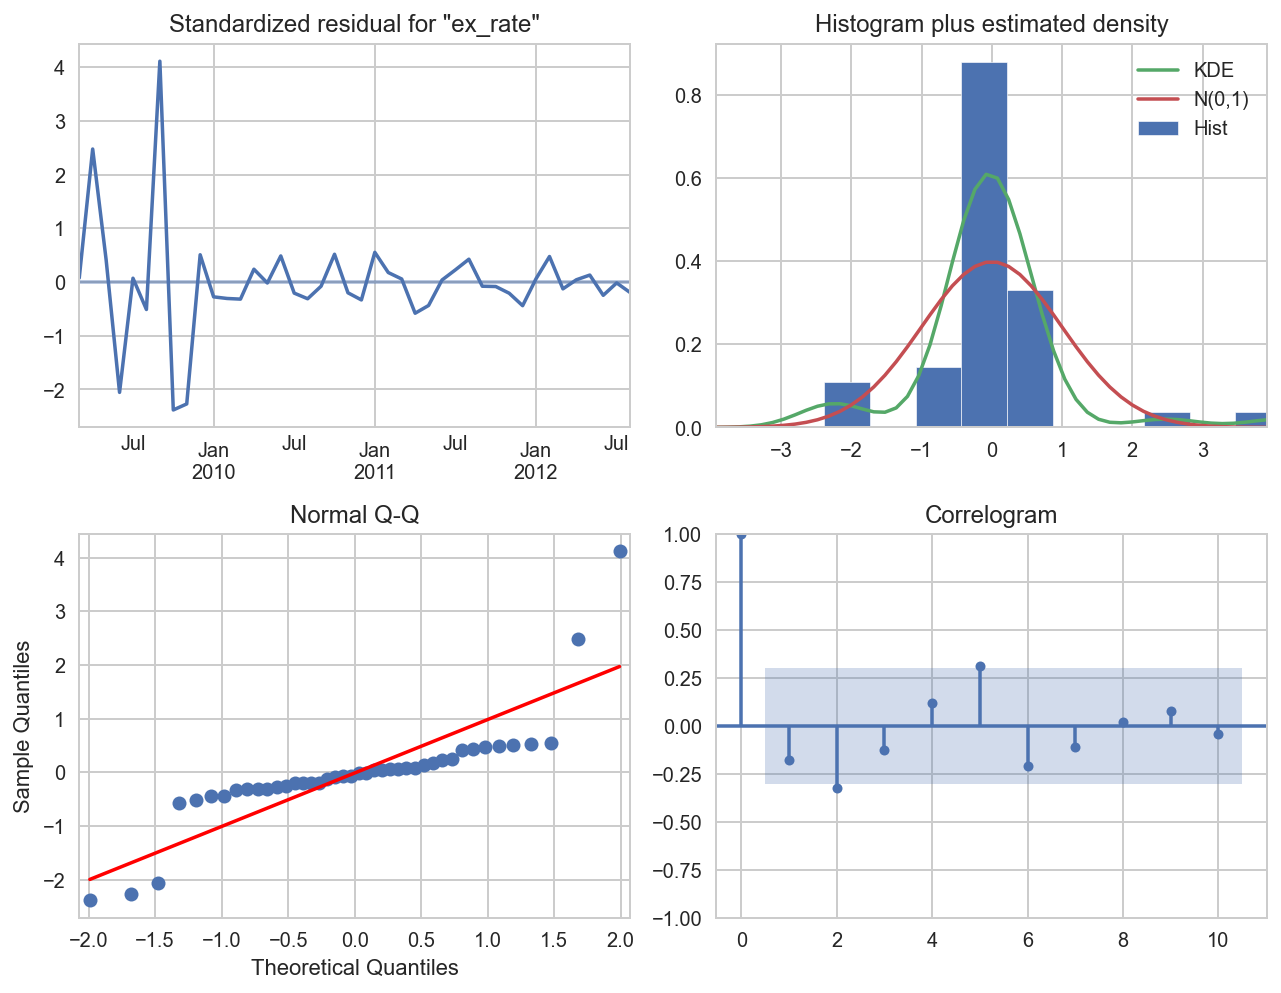

In [12]:
fig, ax = plt.subplots(figsize=(9,7), tight_layout=True)
fig.clear()
model.plot_diagnostics(variable=0, fig=fig)
plt.show()

In [10]:
model.get_forecast(7).summary_frame(endog=1)

money_supply,mean,mean_se,mean_ci_lower,mean_ci_upper
2012-09-01,220783.357572,102249.700313,20377.627528,421189.087616
2012-10-01,206025.704672,111667.807843,-12839.176933,424890.586277
2012-11-01,204141.384441,112023.610686,-15420.857921,423703.626804
2012-12-01,202818.011280,112098.685311,-16891.374644,422527.397203
2013-01-01,202643.613557,112101.533046,-17071.353825,422358.580939
2013-02-01,202519.919885,112102.249296,-17196.451322,422236.291092
2013-03-01,202501.468416,112102.277431,-17214.957934,422217.894766


In [11]:
model.forecast(steps=7)

,ex_rate,money_supply,inf
2012-09-01,116.385561,220783.357572,-0.886404
2012-10-01,118.620922,206025.704672,-0.569714
2012-11-01,127.952594,204141.384441,-0.510029
2012-12-01,128.653998,202818.011280,-0.445874
2013-01-01,129.738022,202643.613557,-0.423876
2013-02-01,129.917587,202519.919885,-0.410325
2013-03-01,130.070560,202501.468416,-0.404707


In [27]:
dfForecastDif = model.forecast(steps=7)
dfForecast = dfCpi.iloc[-1].values.reshape(1,-1) + dfForecastDif.cumsum(axis=0)
dfForecast

,ex_rate,money_supply,inf
2012-09-01,23301.385561,1.042758e+07,2.553596
2012-10-01,23420.006482,1.063360e+07,1.983882
2012-11-01,23547.959076,1.083775e+07,1.473853
2012-12-01,23676.613074,1.104056e+07,1.027979
2013-01-01,23806.351097,1.124321e+07,0.604103
2013-02-01,23936.268683,1.144573e+07,0.193778
2013-03-01,24066.339243,1.164823e+07,-0.210929


## 2. ETS
ETS (Error, Trend and Seasonality) is the [state-space](https://www.statsmodels.org/dev/statespace.html) form of Holt-Winters' method, which adds seasonality and trend to the simple *exponetial smoothing* model. The naive method assumes that only most recent observations are the most important ones.

### 2.1. Holt-Winters' method

#### Level component
First, we go through the most basic foundation: exponential smoothing. A common sense is that most recent data should have a higher influence to the current value rather than further observations. Thus, we attach *exponentially decreasing weights* to observations, described as a *smoothing parameter*, $\alpha$ (for $0\leq\alpha\leq1$). The 1-step ahead forecast is given by the equation:

$$\hat{y}_{T+1|T}=\alpha y_T+\alpha(1-\alpha)y_{T-1}+\alpha(1-\alpha)^2y_{T-2}+\dots$$

The function is smartly designed, so that the sum of weights tends to reach $1$, especially when $T$ is large enough. This is because:

$$
\lim_{T\rightarrow\infty}\sum_{t=0}^{T-1}(1-\alpha)^t
=\lim_{T\rightarrow\infty}\frac{1-(1-\alpha)^T}{\alpha}
=\frac{1}{\alpha}
$$

The above function can be approximated using a recursion: $\hat{y}_{T+1|T}=\alpha y_{T}+(1-\alpha)\hat{y}_{T|T-1}$. Rewriting it gives us the very first component of ETS, the level $l_t$, represented as a weighted average between the last observation ($y_t$) and the last calculated level ($l_{t-1}$).

$$\begin{aligned}
  \hat{y}_{t+h|t} & = l_{t}\\
  l_{t}        & = \alpha y_{t} + (1 - \alpha)l_{t-1}
\end{aligned}$$

- $\hat{y}_{t+h|t}$ is a fitted value for $t=1,2,\dots,T-1$ and $h=1$
- $\hat{y}_{t+h|t}$ is a forecast for $t=T$ and $h=1,2,\dots$

The level component is parameterized by $\alpha$ and $l_0$ (the initial value to calculate $l_1$). Notice that the forecast function returns a *flat forecast*, as it does not depend on $h$.

#### Trend component
If we think the level at time $t$ as some sort of *intercept*, then we need a *slope*. Let's denote it $b_t$ and model it using the last *instantaneous velocity* ($l_t-l_{t-1}$) and, of course, the last value of its own sequence ($b_{t-1}$):

$$b_t=\beta'(l_t-l_{t-1})+(1-\beta')b_{t-1}$$

Here, $\beta'\,(0\leq\beta'\leq1)$ is a smothing parameter. By plugging in the equation for $l_t$ and denoting $\beta=\alpha\beta'\,(0\leq\beta\leq\alpha)$, we can extend the simple exponential smoothing equation:

$$\begin{aligned}
  \hat{y}_{t+H|t} &= l_t + Hb_t \\
  l_t             &= \alpha y_{t} + (1-\alpha)(l_{t-1}+b_{t-1}) \\
  b_t             &= \beta(y_t-l_{t-1}) + (1-\beta)b_{t-1}
\end{aligned}$$

Holt, the author of this method named it *trend*, but keep in mind that it is not the same *trend* as in component decomposition. An important conslusion can be drawn from the formulation is that the forecast function is now a linear function of $h$ rather than a constant. This function is less naive, but tends to overforecast in further horizons. This is the motivation for a damping parameter, $\phi\,(0\leq\phi\leq1)$, which has proven its success and popularity in forecasting tasks. The equation for damped trend is given by:

$$\begin{aligned}
  \hat{y}_{t+H|t} &= l_t + (\phi+\phi^2+\dots+\phi^H)b_t \\
  l_t             &= \alpha y_{t} + (1-\alpha)(l_{t-1}+\phi b_{t-1}) \\
  b_t             &= \beta(y_t-l_{t-1}) + (1-\beta)\phi b_{t-1}
\end{aligned}$$

If $\phi=1$ then there is no damping at all, while a lower value of $\phi$ indicates a very strong damping effect. In practice, $\phi$ should not be less than $0.8$. In addition to $\beta$ and $\phi$, trend component also has the initial value $b_0$ as a parameter.

#### Seasonality component
The seasonal part ($s_t$) in ETS requires a pre-selected seasonal period ($m$), and the same number of seasonal initial values ($s_{-m+1},s_{-m+2},\dots,s_0$). For example, to model quarterly data ($m=4$), the intial values are $s_{-3},s_{-2},s_{-1},s_0$. The equation for seasonal component stand alone is expressed by the weighted average of the current seasonal term ($y_t-l_t$) and the last seasonal term ($s_{t-m}$) :

$$s_t=\gamma'(y_t-l_t)+(1-\gamma')s_{t-m}$$

$0\leq\gamma'\leq1$ is a smoothing parameter. If we substitute $l_t$ from the smoothing equation and $\gamma=(1-\alpha)\gamma'\,(0\leq\gamma\leq1-\alpha)$, we end up getting the complete ETS model. When expressing the equations, the damping factor is removed for simplification purposes.

$$\begin{aligned}
  \hat{y}_{t+H|t} &= l_{t} + Hb_{t} + s_{t+H-m(k+1)} \\
  l_t &= \alpha(y_{t} - s_{t-m}) + (1 - \alpha)(l_{t-1} + b_{t-1}) \\
  b_{t} &= \beta(y_t-l_{t-1}-s_{t-m})+(1-\beta)b_{t-1} \\
  s_t &= \gamma (y_{t}-l_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m}
\end{aligned}$$

The term $s_{t+H-m(k+1)}$ where $k=\lfloor(H-1)/m\rfloor$ may look ugly, but it is just the seasonal term of the same index last observed period.

### 2.2. ETS model

#### ETS function
[State space](https://www.statsmodels.org/dev/statespace.html) is an abstract representation of time series models, including both ARIMA and Holt-Winters. For Holt-Winters only, each of its components (or *states*) can be represented as an equation of *error*. This state space form has a better readability than Holt-Winters' function.

$$\begin{aligned}
    y_t &= l_{t-1}+\phi b_{t-1}+s_{t-m}+\epsilon_t \\
    l_t &= l_{t-1}+\phi b_{t-1}+\alpha\epsilon_t \\
    b_t &= \phi b_{t-1}+\beta\epsilon_t \\
    s_t &= s_{t-m}+\gamma\epsilon_t
\end{aligned}$$

Each component of error, trend and seasonality has two forms: additive and multiplicative. To distinguish between different combinations, we use the syntax: $\text{ETS}(\cdot\cdot\cdot)$, in which each dot stands for the form of the corresponding component: error, trend and seasonality. For example, $\text{ETS(A,Md,M)}$ stands for an ETS model with additive error, damped multiplicative trend and multiplicative seasonality.

#### Procedure
- *Estimation*. Like ARIMA, ETS also estimates its parameters either by minimizing sum of squared error or maximizing the likelihood that error follows a normal distribution. ETS's parameters are coefficients (both smoothing and damping): $\alpha$, $\beta$, $\gamma$ and $\phi$ and initial values: $l_0$, $b_0$ and $s_0,s_{-1},\dots,s_{-m+1}$.

- *Point forecasting*. When forecasting future points using ETS equations ($t>T$), we only need to set $\epsilon_t=0$. For further forecasts ($H>1$), the same *recursion* fashion used in ARIMA is applied.

- *Prediction interval*. ETS also uses forecast variance to add confidence interval to point forecast. The formulas gets more and more complicated as we add more components and use multiplicative method, so they aren't going to be presented here.

#### Model selection
Model selection for ETS is the process of choosing the appropriate form for each component. Like in ARIMA, this can be done by minimizing information criteria (AIC, AICc and BIC). But as there are only a few number of combinations ($2^4=16$), we'd better use Machine Learning's approach that exhausted searches for the best score (MAE, MSE or R2) on an observed validation set.

Some models, particularly $\text{ETS}(\text{A}\cdot\text{M})$ (additive error, multiplicative seasonal and any type of trend), can be excluded from our search and help reducing the computation time. These are potentially unstable models who suffer from division by very small numbers.

### 2.3. Implementation
We can implement Holt-Winters' model via class [`ExponentialSmoothing`] or ETS model via class [`ETSModel`]. Both classes share the same hyperparameters, the later class sacrifies the capability of extracting model components (level, trend and season) in trade-off for generalization.

- `error`: the type of error model, defaults to *add*. The other option is *mul*.
- `trend`: the type of trend model, defaults to *None*. Other options are *add* and *mul*.
- `damped_trend`: whether to use damping factor in the trend model, defaults to *False*. The other option is *True*.
- `seasonal`: the type of seasonality model, defaults to *None*. Other options are *add* and *mul*.
- `seasonal_periods`: the length of a season, defaults to *None*. Must be an integer if seasonal model is used.

[`ExponentialSmoothing`]: https://www.statsmodels.org/devel/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html
[`ETSModel`]: https://www.statsmodels.org/devel/generated/statsmodels.tsa.exponential_smoothing.ets.ETSModel.html

In [28]:
import numpy as np
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from statsmodels.tsa.exponential_smoothing.ets import ETSModel as ETS
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HW

from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, r2_score as R2

import warnings
warnings.filterwarnings('ignore')

In [104]:
dfQuantity = pd.read_csv('../data/purchase_quantity.csv')
dfQuantity = dfQuantity.assign(date=dfQuantity.date.astype('datetime64'))
s = dfQuantity.set_index('date').quantity
s.head()

date
2019-10-28    379.49
2019-10-29    669.51
2019-10-30    337.17
2019-10-31    603.74
2019-11-01    189.82
Name: quantity, dtype: float64

In [140]:
nTest = 30

cutEnd = dfQuantity.shape[0]
cutTest = cutEnd - nTest

x_test, y_test = s[:cutTest], s[cutTest:]

In [153]:
model = ETS(x_test, trend='add', damped_trend=True, seasonal='add', seasonal_periods=30, freq='D').fit()
result = model.summary().tables

In [142]:
result[0]

Dep. Variable:,quantity,No. Observations:,219
Model:,ETS(AAdA),Log Likelihood,-1529.151
Date:,"Tue, 07 Jun 2022",AIC,3132.302
Time:,16:43:02,BIC,3257.698
Sample:,10-28-2019,HQIC,3182.946
,- 06-02-2020,Scale,67980.277
Covariance Type:,approx,,


In [143]:
result[2]

Ljung-Box (Q):,70.89,Jarque-Bera (JB):,196.46
Prob(Q):,0.00,Prob(JB):,0.00
Heteroskedasticity (H):,3.24,Skew:,-0.58
Prob(H) (two-sided):,0.00,Kurtosis:,7.49


In [147]:
forecaster = model.get_prediction(cutTest, cutEnd-1)
y_test_pred = forecaster.predicted_mean.rename('forecast')
dfForecast = y_test_pred.to_frame()
dfForecast['truth'] = y_test
listCi = [0.9, 0.95, 0.99]
for ci in listCi:
    strCi = int(ci*100)
    dfCi = forecaster.summary_frame(alpha=1-ci)
    dfCi = dfCi.iloc[:, -2:]
    dfForecast[[f'ci_{strCi}_lower', f'ci_{strCi}_upper']] = dfCi
dfForecast.tail()

,forecast,truth,ci_90_lower,ci_90_upper,ci_95_lower,ci_95_upper,ci_99_lower,ci_99_upper
2020-06-28,505.658104,0.00,-934.301371,1945.617578,-1210.159440,2221.475647,-1749.308387,2760.624594
2020-06-29,415.254539,304.24,-1050.717878,1881.226956,-1331.559337,2162.068415,-1880.448038,2710.957116
2020-06-30,467.350354,661.91,-1024.181410,1958.882118,-1309.919363,2244.620071,-1868.377982,2803.078690
2020-07-01,409.722661,729.94,-1106.937785,1926.383108,-1397.489727,2216.935050,-1965.357015,2784.802338
2020-07-02,510.193281,608.80,-1031.186243,2051.572805,-1326.473705,2346.860268,-1903.596300,2923.982862


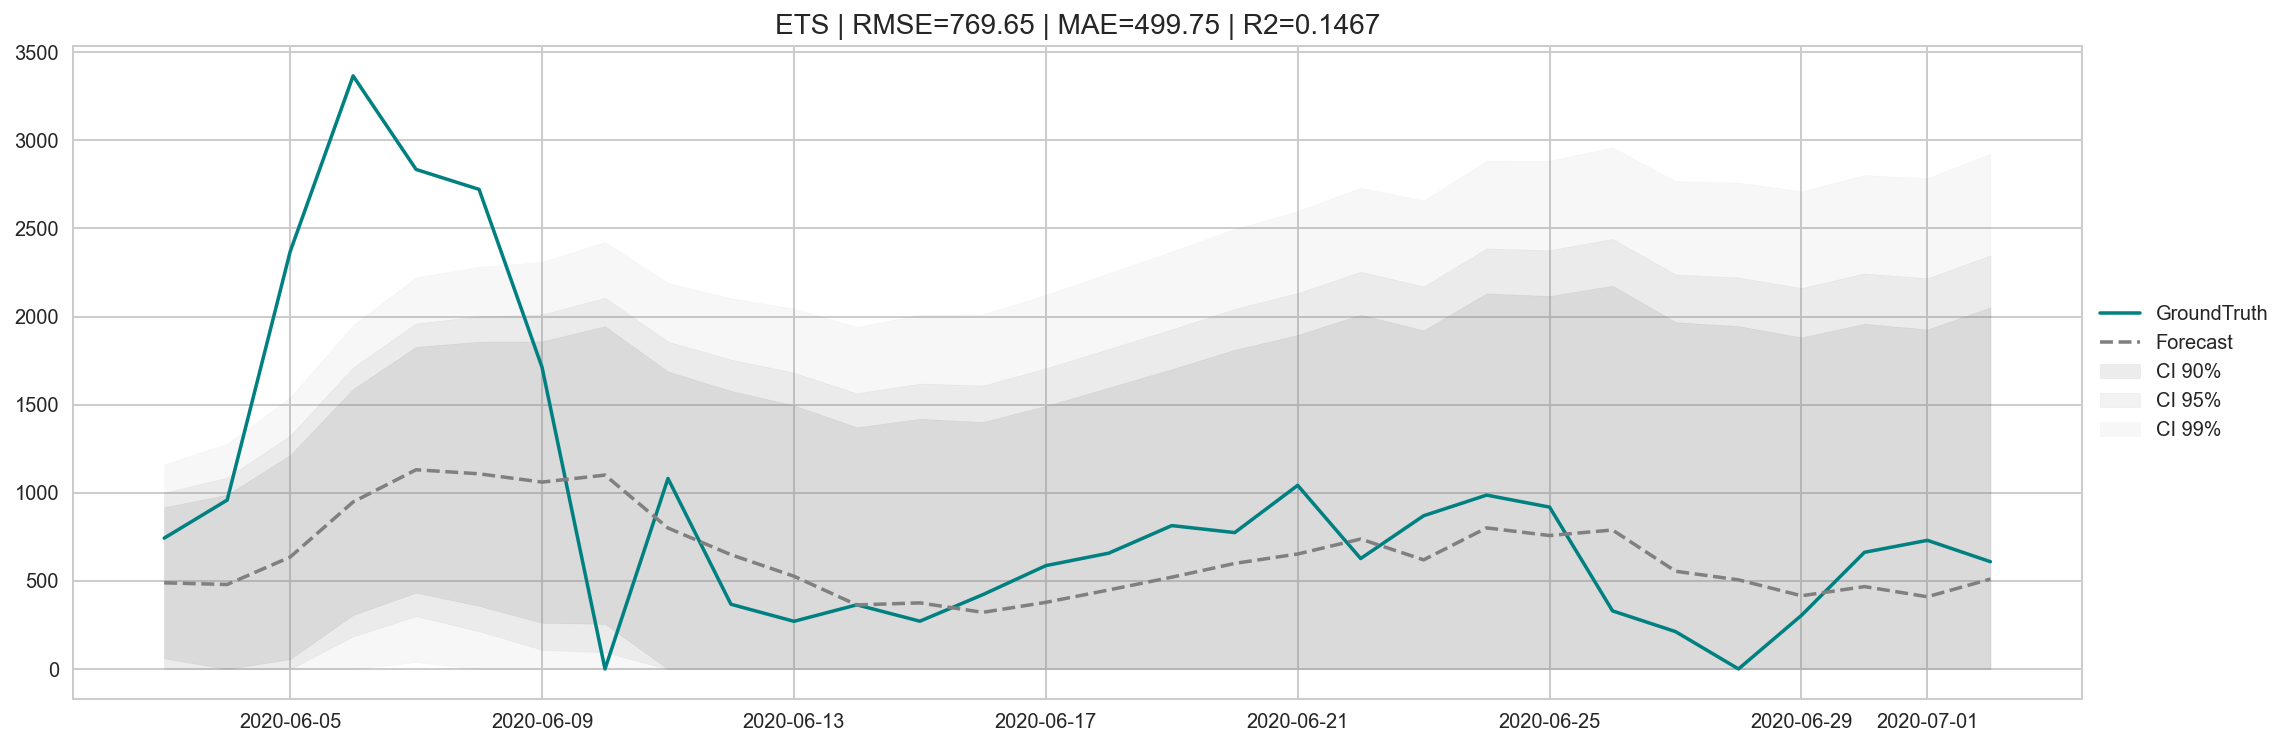

In [150]:
df = dfForecast.copy()
df = df.clip(lower=0)

rmse = MSE(y_test, y_test_pred, squared=False)
mae = MAE(y_test, y_test_pred)
r2 = R2(y_test, y_test_pred)
title = f'ETS | RMSE={rmse:.2f} | MAE={mae:.2f} | R2={r2:.4f}'

fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df.truth, color='teal', label='GroundTruth')
ax.plot(df.forecast, '--', c='grey', label='Forecast')
for ci in listCi:
    alpha = 1 - ci + 0.05
    strCi = int(ci*100)
    lower, upper = df[f'ci_{strCi}_lower'], df[f'ci_{strCi}_upper']
    ax.fill_between(df.index, lower, upper, color='grey', alpha=alpha, label=f'CI {strCi}%')
ax.legend(bbox_to_anchor=(1, 0.5), loc='center left')
ax.set_title(title, fontsize=14)
plt.show()

## 3. TBATS
TBATS (Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal components) is a combination of ARMA and Holt-Winters' methods, with Fourier series to handle multiple, non-integers seasonal periods. This type of seasonality is popular in business time series, for example, daily data usually has weekly ($m_1=7$) as well as annual ($m_2=365.25$) patterns.

### 3.1. TBATS model
TBATS model is described in the following equations:

$$\begin{aligned}
y_t^{(\lambda)} &= l_{t-1}+\delta b_{t-1}+s_{t-m}+d_t \\
l_t &= l_{t-1}+\delta b_{t-1}+\alpha d_t \\
b_t &= \delta b_{t-1}+\beta d_t \\
d_t &= (\phi_1 d_{t-1}+\dots+\phi_p d_{t-p})+(\theta_1 d_{t-1}+\dots+\theta_q d_{t-q})+\epsilon_t \\
\end{aligned}$$

Here, $l_t$ and $b_t$ are trend and damped slope components, $d_t$ refers to $\text{ARMA}(p,q)$. The operator $\lambda$ stands for Box-Cox transformation, which allows capturing non-linear patterns. $s_t$ in the above equation is a seasonal component; as it is the most complicated part of TBATS, we only express a single component to make things as simple as possible. To model multiple seasonal periods, we simple add more $s_t$ components. Each component $s_t$ is modeled as the sum of $K$ harmonics: $s_t = s_{1,t}+\dots+s_{K,t}$. Each harmonic $s_{k,t}$ is given by:

$$\begin{aligned}
s_{k,t} &= s_{k,t-1}\cos(w) + s'_{k,t-1}\sin(w) + \gamma_1d_t \\
s'_{k,t} &= -s_{k,t-1}\sin(w) + s'_{k,t-1}\cos(w) + \gamma_2d_t
\end{aligned}$$

$w=2\pi k/m$, where $m$ is the length of seasonal period, $s'_{k,t}$ is just a subsidiary variable presented to compute $s_{k,t}$.

### 3.2. Implementation
TBATS is implemented in Sktime via class [`TBATS`]. The hyperparameters are:
- `use_box_cox`: whether to use Box-Cox transform, defaults to *None* (automated). Other options are *True* and *Fasle*.
- `use_trend`: the type of trend model, defaults to *None*. Other options are *add* and *mul*.
- `use_damped_trend`: whether to use damping factor in the trend model, defaults to *False*. The other option is *True*.
- `use_arma_errors`: the type of seasonality model, defaults to *None*. Other options are *add* and *mul*.
- `sp`: the length of a season, defaults to *None*. Must be an integer if seasonal model is used.

[`TBATS`]: https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.tbats.TBATS.html

## 4. Prophet
[Prophet](https://facebook.github.io/prophet/) is proposed in the paper [Forecasting at Scale](https://peerj.com/preprints/3190.pdf) (2017) by Facebook. It has so many advantages and is widely used in forecasting tasks.
- It is fast and accurate
- Requires no manual effort and is robust to outliers, missing data and dramatically changes
- Accepts domain knowledge

### 4.1. Algorithm
Prophet decomposes our time series into three components: trends, seasonality, holidays and combines them in an additive model. The parameters of each model are estimated using [MAP](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) (Maximum A Posterior).

$$\hat{y}_t=g(t)+s(t)+h(t)+\epsilon_t$$

Here:
- $g(t)$ is the trend function which models *non-periodic* changes in the time series
- $s(t)$ models periodic changes (yearly, weekly and daily seasonality)
- $h(t)$ is the model of holidays which occur irregularly
- $\epsilon_t$ is the irreducible error term, it should follow a normal distribution

#### Trend component
Prophet's trend function is capable of modeling two types of trend:
- Linear growth (via a linear function): $g(t)=kt+m$
- Saturating growth (via a logistic function): $g(t)=\dfrac{C}{1+\exp(-k(t-m))}$

where $k$ is the growth rate, $m$ is an offset parameter and $C$ is the carrying capacity. The trend model is even extended so that it can handle change-points. Let's say there are $S$ change-points, each denoted $y_s$ for $s=1,2,\dots,S$. Prophet assumes that the rate and offset at time $t$ is the sum of base value plus all of the adjustments up to that point. We then define a *mask* vector (which is useful at expressing adjustments), $\mathbf{a}(t)\in\{0,1\}^S$, such that:

$$a_s(t)=\begin{cases}
1 &\text{if }t>s \\
0 &\text{otherwise}
\end{cases}$$

The adjustments of growth rate at different change-points is denoted by a vector, $\boldsymbol{\delta}\in\mathbb{R}^S$. For offset, its adjustment vector, denoted $\boldsymbol{\gamma}\in\mathbb{R}^S$, is more complicated: $\gamma_s$ is computed using all previous values of $\boldsymbol{\delta}$ and $\boldsymbol{\gamma}$. The updated value for $k$ and $m$ is then given by:

$$\begin{aligned}
k &\leftarrow k+\mathbf{a}(t)^{\text{T}}\boldsymbol{\delta} \\
m &\leftarrow m+\mathbf{a}(t)^{\text{T}}\boldsymbol{\gamma}
\end{aligned}$$

Change-points can be either defined explicitly by analysts (for example, the known dates of product launches) or detected automatically by Prophet. A large number of potential change-points are initialized equally-spaced on the first 80% of the time series. Then Prophet uses the prior $\boldsymbol{\delta}\sim\text{Laplace}(0,\tau)$, where $\tau$ controls the flexibility of the trend model. The [Laplace distribution] is used here due to its concentration to its location, making $\boldsymbol{\delta}$ favours 0. Such a sparse vector ensures most of the candidates are not going to be used. The larger $\tau$ is, the less sparse $\boldsymbol{\delta}$ is and the more flexible the trend model is.

[Laplace distribution]: https://en.wikipedia.org/wiki/Laplace_distribution

#### Seasonality component
Prophet relies on [Fourier series] to provide a flexible model of periodic effects. Let $m$ be the period we expect the time series to have (e.g. $m=365.25$ for yearly data, $m=7$ for weekly data when our time series is given in days). The formula for seasonality at time $t$ is approximated with a standard Fourier series:

$$s(t)=\sum_{n=1}^{N}{\left(a_n\cos\frac{2\pi nt}{m}+b_n\sin\frac{2\pi nt}{m}\right)}$$

Fitting seasonality is the process of estimating $2N$ parameters $\boldsymbol{\beta}=(a_1,b_1,a_2,b_2,\dots,a_N,b_N)$. Prophet takes $\boldsymbol{\beta}\sim\mathcal{N}(0,\sigma^2)$ to impose a smoothing prior on the seasonality. When $N$ is too large, seasonal patterns may change very quickly and thus we risk overfitting. In practice, selecting $N=3$ for weekly seasonality and $N=10$ for yearly seasonality is a good rule of thumb. Optimal value for $N$ can also be found via model selection procedure that minimizes AIC.

[Fourier series]: https://en.wikipedia.org/wiki/Fourier_series

#### Holidays and events
Holidays and events cause large, non-periodic but somewhat predictable shocks to business time series. Prophet assumes that not only a holiday, but also other days surrounding it, have effects on our time series. let's say at holiday number $i$, denote $D_i$ the window which specifies the surrounding days and $\kappa_i$ the coefficient attached to the corresponding window. The holiday model is given by:

$$h(t)=\mathbf{Z}(t)\boldsymbol{\kappa}$$

where:
- $\mathbf{Z}(t)=[\mathbf{1}_{t\in D_1},\dots,\mathbf{1}_{t\in D_I}]$ is the matrix of regressors
- $\boldsymbol{\kappa}$ is the vector of coefficients, the prior is $\boldsymbol{\kappa}\sim\mathcal{N}(0,\nu^2)$

### 4.2. Implementation

#### Hyperparameters tuning
- `growth`: the type of trend, linear or saturating, defaults to *linear*. The other option is *logistic*.
- `changepoints`: a custom list of dates provided by analysts when change-points happen, defaults to *None*.
- `n_changepoints`: the number of initial change-points, defaults to *25*.
- `changepoint_range`: the proportion of history data in which potential change-points are initialized on, defaults to *0.8* (for the first 80% historical data).
- `changepoint_prior_scale`: the value of $\tau$, defaults to *0.05*. Larger values allow more change-points but can lead to overfitting.
- `yearly_seasonality`, `weekly_seasonality` and `daily_seasonality`: how the respective seasonality is fitted, all default to *auto*. Other options are *True*, *False* or an integer representing $N$.
- `seasonality_mode`: the type of seasonality model, defaults to *additive*. The other option is *multiplicative*.
- `holidays_prior_scale`: the value of $\nu$, defaults to *10*. This parameter indicates the strength of the holiday model, reducing it dampens holiday effects.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from prophet import Prophet as FBProphet
from sktime.forecasting.fbprophet import Prophet

from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, r2_score as R2

import warnings; warnings.filterwarnings('ignore')

In [2]:
dfQty = pd.read_csv('../data/purchase_quantity.csv')
dfQty = dfQty.assign(date=dfQty.date.astype('datetime64'))
# dfQty = dfQty.rename(columns={'date': 'ds', 'quantity': 'y'})
sQty = dfQty.set_index('date').asfreq('d').quantity.fillna(1e-6)
sQty

date
2019-10-28    379.490000
2019-10-29    669.510000
2019-10-30    337.170000
2019-10-31    603.740000
2019-11-01      0.000001
                 ...    
2020-02-03    119.320000
2020-02-04      0.000000
2020-02-05    303.440000
2020-02-06    553.960000
2020-02-07    608.800000
Freq: D, Name: quantity, Length: 103, dtype: float64

In [4]:
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(sQty)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Prophet(daily_seasonality=True, yearly_seasonality=True)

In [5]:
model.predict(fh=np.arange(1,7))

2020-02-08    252.915024
2020-02-09    193.117611
2020-02-10    280.511671
2020-02-11    391.861825
2020-02-12    295.434570
2020-02-13    330.742117
dtype: float64

In [6]:
model.predict_interval(fh=np.arange(1,7), coverage=[0.05, 0.1])

Coverage                                    
                  0.05                    0.10            
                 lower       upper       lower       upper
2020-02-08  254.168651  280.742016  202.216014  273.927036
2020-02-09  172.310948  195.808734  176.280255  233.759795
2020-02-10  272.264457  291.308642  265.284647  309.547861
2020-02-11  391.172134  416.670542  364.299067  414.529717
2020-02-12  289.686974  320.713603  274.673913  324.429586
2020-02-13  312.146907  340.366883  318.463305  366.970234

## Resources
- *otexts - [Forecasting: Principles and Practice](https://otexts.com/fpp3/)*
- *openforecast - [Forecasting and Analytics with Adam](https://www.openforecast.org/adam/)*
- *online.stat.psu - [STAT 510: Applied Time Series Analysis](https://online.stat.psu.edu/stat510/)*
- *robjhyndman - [Forecasting time series with complex seasonal patterns using exponential smoothing](https://robjhyndman.com/papers/ComplexSeasonality.pdf)*